## 개, 고양이 분류 (Partial) - CNN v1
- partial data =  training dog: 1000, cat: 1000 ; test dog: 500, cat: 500
- No image Centering

In [9]:
import wget
import zipfile

In [8]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
wget.download(url)

'cats_and_dogs_filtered.zip'

In [10]:
path_to_zip_file = 'cats_and_dogs_filtered.zip'
directory_to_extract_to = './data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

#### Import Library and EDA

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
train_dir = './data/cats_and_dogs_filtered/train'
validation_dir = './data/cats_and_dogs_filtered/validation'
train_cats_dir = './data/cats_and_dogs_filtered/train/cats'
train_dogs_dir = './data/cats_and_dogs_filtered/train/dogs'
validation_cats_dir = './data/cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = './data/cats_and_dogs_filtered/validation/dogs'

In [13]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']


In [14]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

In [15]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'./data/cats_and_dogs_filtered/train/cats\\cat.475.jpg'

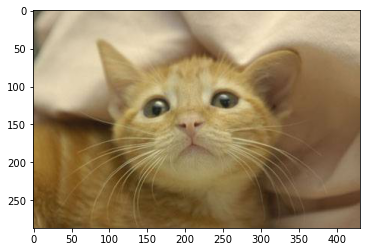

In [16]:
# 1) Pillow image
from PIL import Image
img = Image.open(fname)
plt.imshow(img);

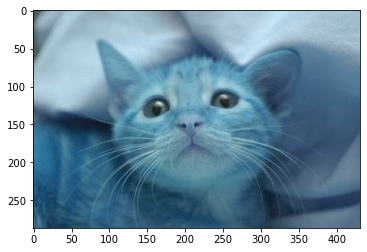

In [19]:
# 2) OpenCV image, 순서가 RGB가 아니고, BGR로 읽음
import cv2
img2 = cv2.imread(fname)
plt.imshow(img2);

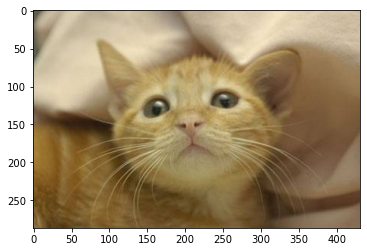

In [20]:
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3)

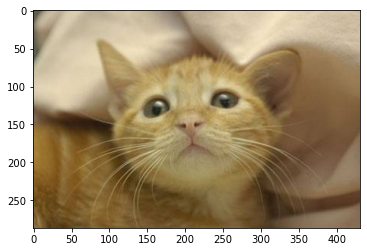

In [21]:
# OpenCV의 데이터는 numpy array
img2 = img2[:,:,::-1]
plt.imshow(img2);

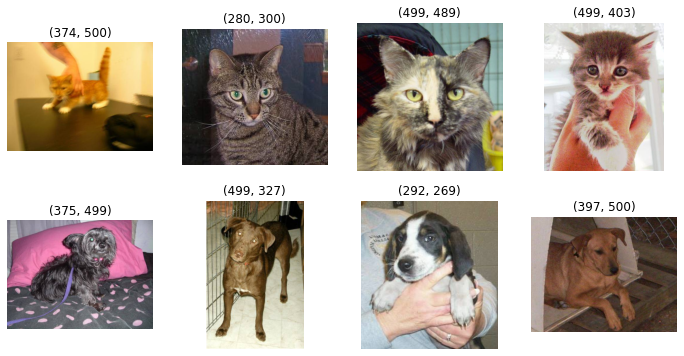

In [22]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

#### Modeling

In [24]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [25]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [26]:
model_path = './models/best-cats-and-dogs-v1.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
hist = model.fit(
    train_generator, 
    validation_data=test_generator,
    epochs=100, steps_per_epoch=100,
    validation_steps=50, callbacks=[mc, es]
)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.6803
Epoch 00001: val_loss improved from 0.67573 to 0.65018, saving model to ./models\best-cats-and-dogs-v1.h5
100/100 [==============================] - 6s 57ms/step - loss: 0.5932 - accuracy: 0.6810 - val_loss: 0.6502 - val_accuracy: 0.6520
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5235 - accuracy: 0.7414
Epoch 00002: val_loss improved from 0.65018 to 0.63074, saving model to ./models\best-cats-and-dogs-v1.h5
100/100 [==============================] - 6s 56ms/step - loss: 0.5227 - accuracy: 0.7415 - val_loss: 0.6307 - val_accuracy: 0.6710
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.7909
Epoch 00003: val_loss did not improve from 0.63074
100/100 [==============================] - 6s 55ms/step - loss: 0.4453 - accuracy: 0.7910 - val_loss: 0.6850 - val_accuracy: 0.6810
Epoch 4/100
 99/100 [============================>

In [32]:
best_model = load_model(model_path)

- 테스트 이미지 분류

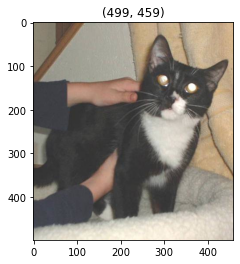

In [38]:
img = cv2.imread('./data/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

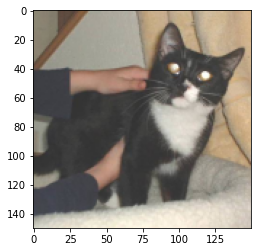

In [39]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [40]:
best_model.predict(img.reshape(1,150,150,3))

array([[0.]], dtype=float32)

## 개, 고양이 분류 (Partial) - CNN v1
- partial data =  training dog: 1000, cat: 1000 ; test dog: 500, cat: 500
- image Centering

#### EDA

In [44]:
# 이미지를 축소/확대 및 센터링해서 이미지를 반환하는 함수
IMAGE_SIZE = 150

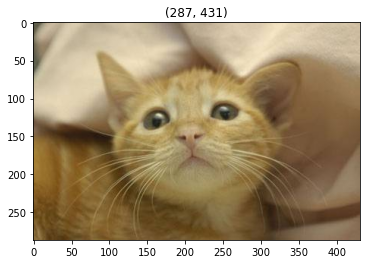

In [45]:
import cv2
fname = './data/cats_and_dogs_filtered/train/cats/cat.475.jpg'
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

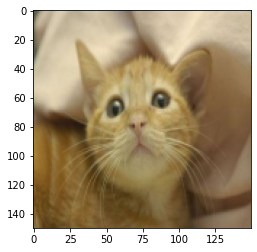

In [46]:
plt.imshow(cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA));

In [47]:
h, w, _ = img.shape
h, w

(287, 431)

In [48]:
if h > w:
    width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
else:
    width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

In [49]:
# Pillow image: new_img = np.array(img.resize((width, height)))
new_img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
new_img.shape

(150, 225, 3)

In [50]:
diff = abs(width - height) // 2

In [51]:
if h > w:
    final_img = new_img[diff:diff+IMAGE_SIZE, :]
else:
    final_img = new_img[:, diff:diff+IMAGE_SIZE]

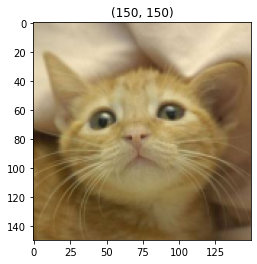

In [52]:
plt.imshow(final_img), plt.title(final_img.shape[:-1]);

In [53]:
from PIL import Image
def center_image(img, src_format='OpenCV', dst_format='OpenCV'):
    if src_format == 'OpenCV':
        h, w = img.shape[:-1]
    else:                       # Pillow
        h, w = np.array(img).shape[:-1]

    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    interpolation = cv2.INTER_AREA if h + w > 300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize=(width, height), interpolation=interpolation)

    diff = abs(width - height) // 2
    if h > w:
        final_img = new_img[diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[:, diff:diff+IMAGE_SIZE]

    return final_img if dst_format == 'OpenCV' else Image.fromarray(final_img)

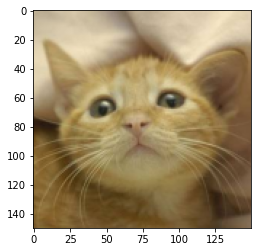

In [54]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(center_image(img));

- 파일을 읽어서 센터 이미지로 변환 후 저장

In [57]:
CENTER_DIR = './data/cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [58]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [59]:
old_train_cats_dir = './data/cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = './data/cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = './data/cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = './data/cats_and_dogs_filtered/validation/dogs'

In [72]:
# cats_and_dogs_filtered -> image 축소/확대후 centering -> cats_and_dogs_centered
from glob import glob

for src_dir in [old_train_cats_dir,old_train_dogs_dir,old_validation_cats_dir,old_validation_dogs_dir]:
    dst_dir = src_dir.replace('filtered', 'centered')
    for fname in glob(f'{src_dir}/*.jpg'):
        dst_fname = fname.split('/')[-1].split('\\')[-1]
        src_img = cv2.imread(fname)[:,:,::-1]
        dst_img = center_image(src_img, src_format='OpenCV', dst_format='Pillow')
        dst_img.save(f'{dst_dir}/{dst_fname}')

In [73]:
# 파일 이름
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

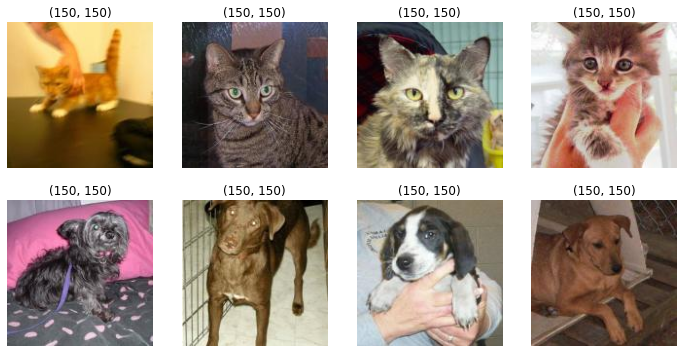

In [74]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

#### Modeling

In [76]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [77]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [78]:
model_path = './models/best-cats-and-dogs-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [82]:
hist = model.fit(
    train_generator, 
    validation_data=test_generator,
    epochs=100, steps_per_epoch=100,
    validation_steps=50, callbacks=[mc, es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9855
Epoch 00001: val_loss did not improve from 0.62802
100/100 [==============================] - 2s 22ms/step - loss: 0.0541 - accuracy: 0.9855 - val_loss: 1.8969 - val_accuracy: 0.6760
Epoch 2/100
 97/100 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9876
Epoch 00002: val_loss did not improve from 0.62802
100/100 [==============================] - 2s 21ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 2.0934 - val_accuracy: 0.6450
Epoch 3/100
 97/100 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9964
Epoch 00003: val_loss did not improve from 0.62802
100/100 [==============================] - 2s 22ms/step - loss: 0.0142 - accuracy: 0.9965 - val_loss: 2.6491 - val_accuracy: 0.6720
Epoch 4/100
 97/100 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9789
Epoch 00004: val_loss did not improve from 0.62802
100/100 [===